# `micapipe v0.2.2` walkthrough

## Objectives

1. To learn how to download an open dataset
2. Validate it with BIDS
3. Prepare the `micapipe` singularity image to run
4. Understan the dataset organization and prepare the script to run `micapipe`
5. Evaluate the outputs of a single subject
6. Run the group QC
7. Revise the group QC pdf report.

## 1. Download a dataset
**MICA-MICs**: a dataset for Microstructure-Informed Connectomics. MICs is hosted on The Canadian Open Neuroscience Platform:  https://portal.conp.ca/dataset?id=projects/mica-mics

<div style="text-align: right">
<a href="https://portal.conp.ca/dataset?id=projects/mica-mics"><img src="https://portal.conp.ca/dataset_logo?id=projects/mica-mics" alt="" width="200" id="hp"/>
</div>
    
> Royer, Jessica, et al. "An open MRI dataset for multiscale neuroscience." Scientific Data 9.1 (2022): 569. https://doi.org/10.1093/brain/awad125


In [1]:
%%bash
cd /data_/mica3/BIDS_MICs/MICs_release/rawdata
tree sub-HC001/ses-01

sub-HC001/ses-01
├── anat
│   ├── sub-HC001_ses-01_acq-inv1_T1map.json
│   ├── sub-HC001_ses-01_acq-inv1_T1map.nii.gz
│   ├── sub-HC001_ses-01_acq-inv2_T1map.json
│   ├── sub-HC001_ses-01_acq-inv2_T1map.nii.gz
│   ├── sub-HC001_ses-01_acq-mp2rage_T1map.json
│   ├── sub-HC001_ses-01_acq-mp2rage_T1map.nii.gz
│   ├── sub-HC001_ses-01_acq-uni_T1map.json
│   ├── sub-HC001_ses-01_acq-uni_T1map.nii.gz
│   ├── sub-HC001_ses-01_run-1_T1w.json
│   ├── sub-HC001_ses-01_run-1_T1w.nii.gz
│   ├── sub-HC001_ses-01_run-2_T1w.json
│   └── sub-HC001_ses-01_run-2_T1w.nii.gz
├── dwi
│   ├── sub-HC001_ses-01_acq-b2000-91_dir-AP_dwi.bval
│   ├── sub-HC001_ses-01_acq-b2000-91_dir-AP_dwi.bvec
│   ├── sub-HC001_ses-01_acq-b2000-91_dir-AP_dwi.json
│   ├── sub-HC001_ses-01_acq-b2000-91_dir-AP_dwi.nii.gz
│   ├── sub-HC001_ses-01_acq-b300-11_dir-AP_dwi.bval
│   ├── sub-HC001_ses-01_acq-b300-11_dir-AP_dwi.bvec
│   ├── sub-HC001_ses-01_acq-b300-11_dir-AP_dwi.json
│   ├── sub-HC001_ses-01_acq-b300-11_dir-AP_dwi.nii.g

# 2. BIDS validation

This dataset is BIDS-compliant, and no further conversion is needed. At this point, MICs is BIDS conform. However, any new dataset that has been recently acquired and that you wish to make BIDS-compliant (see specifications at http://bids-specification.readthedocs.io), should be validated with tools provided by BIDS, such as the BIDS-validator (https://bids-standard.github.io/bids-validator/).

# 3. Prepare the micapipe image

> Require `docker` and `singularity`

From dockerhub micapipe you can copy the code to pull the latest image:
https://hub.docker.com/r/micalab/micapipe

In [2]:
%%bash
docker pull micalab/micapipe:v0.2.2

v0.2.2: Pulling from micalab/micapipe
Digest: sha256:f5888510045d2672fcebb6ae5e710a22f7ad17302247b76ed5e6ea73199181b1
Status: Image is up to date for micalab/micapipe:v0.2.2
docker.io/micalab/micapipe:v0.2.2


Create a singularity image from the docker image:

```bash
singularity build micapipe_v0.2.0.sif docker-daemon://micapipe:v0.2.2
```

In [3]:
%%bash

# path to the singularity image
micapipe_img=$MICAPIPE/micapipe_v0.2.2.sif

# print help from micapipe
singularity run --cleanenv ${micapipe_img} -h

# List the path to the micapipe singularity image
ls $micapipe_img

Some packages in this Docker container are non-free
If you are considering commercial use of this container, please consult the relevant license:
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Licence

COMMAND:
   micapipe


ARGUMENTS:
	-sub 	          : Subject identification
	-out 	          : Output directory for the processed files <derivatives>.
	-bids 	          : Path to BIDS directory
	-ses 	          : OPTIONAL flag that indicates the session name (if omitted will manage as SINGLE session)

   Flags for basic stages of processing:
	-proc_structural  : Volumetric processing
	-proc_surf        : Cortical surface reconstruction processing
			      ( Requires: -proc_structural )

   Flags for second stages of structural processing:
	-post_structural  : Post structural volumetric processing
			      ( Requires: -proc_structural and -proc_surf )
	-proc_dwi         : DWI-Diffusion weighted images processing with MRtrix3
			      ( Requires: -proc_structural )
	-proc_asl         : ASL-Arteria

# 4. Prepare the `micapipe` command

```bash

# Set the variablers
sub=HC001
ses=01

micapipe_img=${MICAPIPE}/micapipe_v0.2.2.sif
bids=/data_/mica3/BIDS_MICs/MICs_release/rawdata
out=/data/mica3/BIDS_MICs/derivatives
fs_lic=/data_/mica1/01_programs/freesurfer-7.3.2/license.txt
tmp=/data/mica2/temporaryNetworkProcessing


# Run micapipe
singularity run --cleanenv \
	-B ${bids}:/bids \
	-B ${out}:/out \
	-B ${tmp}:/tmp \
	-B ${fs_lic}:/opt/licence.txt \
	${micapipe_img} \
	-bids /bids -out /out -fs_licence /opt/licence.txt -threads 10 -sub ${sub} -ses ${ses} \
    -proc_structural -proc_surf -surf_dir /out/freesurfer/${sub}_${ses} -freesurfer \
    -post_structural -proc_flair -GD -proc_func -MPC -mpc_acq T1map -regSynth -proc_dwi -SC

```

# 5. Evaluate a single subject outputs

In [21]:
%%bash
# Change directory to the subject processed
cd /data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0/sub-HC001/ses-01

# Print the directory tree
tree -d


.
├── anat
├── dist
├── dwi
├── func
│   └── desc-se_task-rest_acq-AP_bold
│       ├── surf
│       └── volumetric
├── logs
├── maps
├── mpc
│   └── acq-T1map
├── parc
├── perf
├── QC
├── surf
└── xfm

16 directories


In [4]:
import os
import numpy as np
import nibabel as nb
import matplotlib as plt
import seaborn as sns
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface

sub='sub-HC016'
ses='02'
recon='freesurfer'
derivatives='/data_/mica3/BIDS_MICs/derivatives'
func_acq='desc-se_task-rest_acq-AP_bold'
subjectID=sub+'_ses-02'
out=derivatives+ '/micapipe_v0.2.0/'
subjectDir=out + sub+'/ses-02'

# Set the working directory to the 'out' directory
os.chdir(out) 

# Set paths and variables
dir_FS = derivatives+'/'+recon+'/' + subjectID

# Load native pial surface
def load_surf(label='pial', surf='fsnative'):
    gm_lh = read_surface(subjectDir+'/surf/'+subjectID+'_hemi-L_space-nativepro_surf-'+surf+'_label-'+label+'.surf.gii', itype='gii')
    gm_rh = read_surface(subjectDir+'/surf/'+subjectID+'_hemi-R_space-nativepro_surf-'+surf+'_label-'+label+'.surf.gii', itype='gii')
    return (gm_lh, gm_rh)

def load_feat(label='thickness', surf='fsnative'):
    dat_lh = nb.load(subjectDir+'/maps/'+subjectID+'_hemi-L_surf-'+surf+'_label-'+label+'.func.gii').darrays[0].data
    dat_rh = nb.load(subjectDir+'/maps/'+subjectID+'_hemi-R_surf-'+surf+'_label-'+label+'.func.gii').darrays[0].data
    dat = np.concatenate((dat_lh, dat_rh), axis=0)
    return (dat)

micapipe = os.environ['MICAPIPE']

# fsLR-32k
c69_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.surf.gii', itype='gii')
c69_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.surf.gii', itype='gii')
c69_lhi = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
c69_rhi = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

# fsLR-5k
c5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
c5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')
c5k_lhi = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
c5k_rhi = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

# fsaverage5
fs5_lh = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.pial', itype='fs')
fs5_lhi = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.inflated', itype='fs')
fs5_rhi = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.inflated', itype='fs')

# Colormap
grey = plt.colors.ListedColormap(np.full((256, 4), [0.65, 0.65, 0.65, 1]))


## Subject surfaces

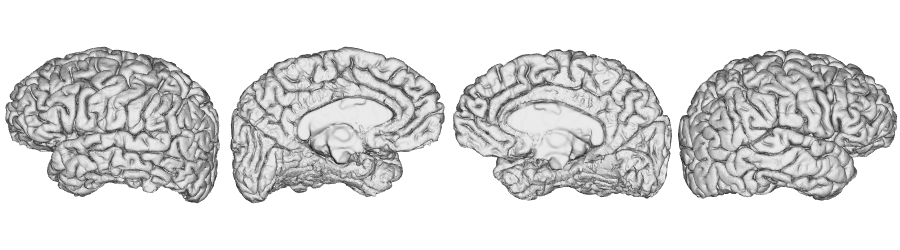

In [8]:
# Plot the surface
gm_lh, gm_rh = load_surf(label='pial', surf='fsnative')
plot_hemispheres(gm_lh, gm_rh, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), transparent_bg=False)

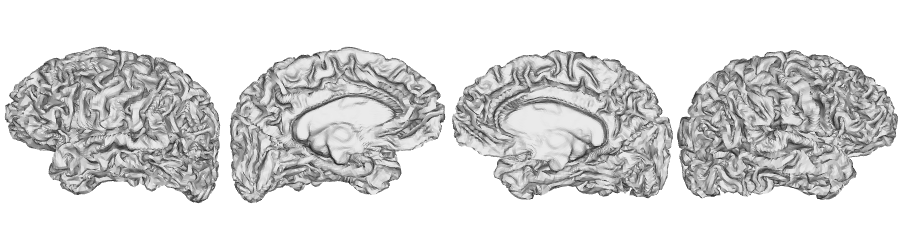

In [11]:
# Plot the surface
gm_lh, gm_rh = load_surf(label='midthickness', surf='fsLR-32k')
plot_hemispheres(gm_lh, gm_rh, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), transparent_bg=False)


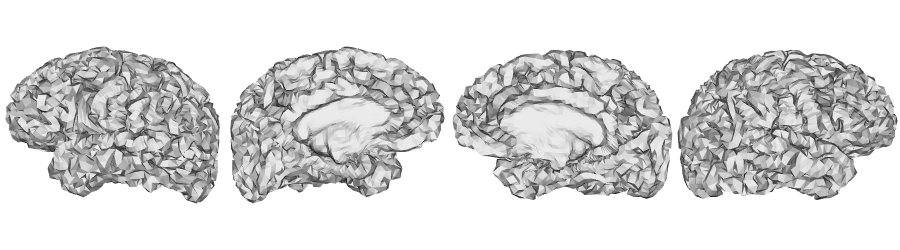

In [12]:
# Plot the surface
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(gm_lh, gm_rh, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), transparent_bg=False)


## Surface derive metrics: Thickness and Curvature

(64984,)


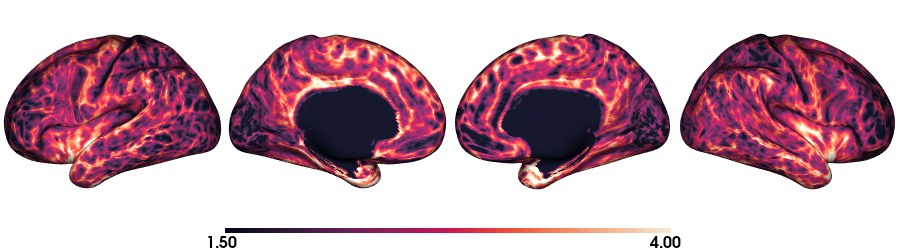

In [13]:
# Plot the surface
feat = load_feat(label='thickness', surf='fsLR-32k')
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-32k')
print(feat.shape)
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False,  color_bar='bottom',
                screenshot=False, filename='/host/yeatman/local_raid/rcruces/tmp/fsLR-32k_inflated_thickness.png')

(9684,)


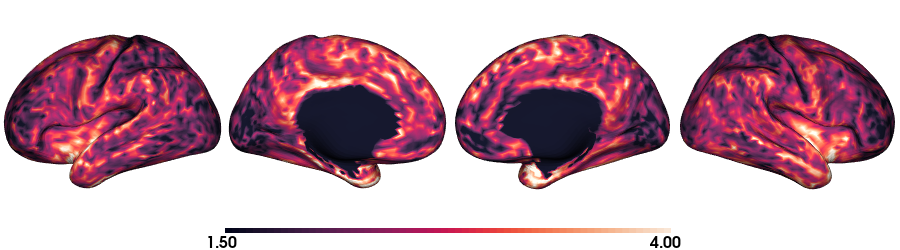

In [14]:
# Plot the surface
feat = load_feat(label='thickness', surf='fsLR-5k')
print(feat.shape)
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-5k')
# Plot the surface
plot_hemispheres(c5k_lhi, c5k_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False,  color_bar='bottom',
                screenshot=False, filename='/host/yeatman/local_raid/rcruces/fsLR-5k_inflated_thickness.png')

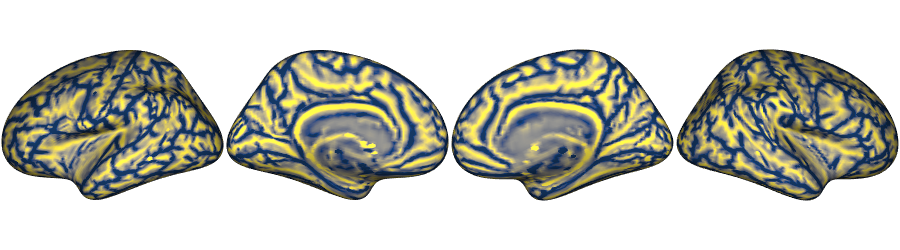

In [15]:
# Plot the surface
feat = load_feat(label='curv', surf='fsaverage5')
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(fs5_lhi, fs5_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(-0.2,0.2), cmap='cividis', transparent_bg=False)

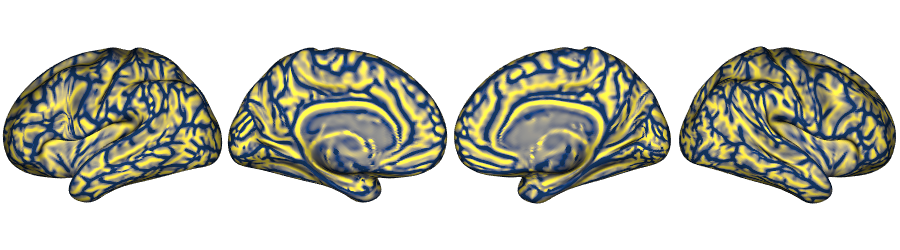

In [16]:
# Plot the surface
feat = load_feat(label='curv', surf='fsLR-32k')
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-32k')
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(-0.2,0.2), cmap='cividis', transparent_bg=False)

## Geodesic distance `-GD`

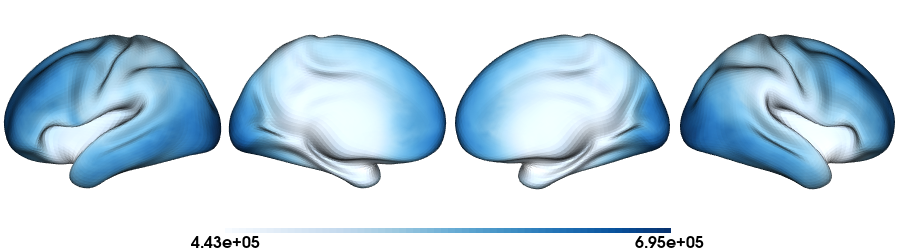

In [17]:
# load the matrix
vtx_gd = nb.load(subjectDir + '/dist/' + subjectID + '_surf-fsLR-5k_GD.shape.gii').darrays[0].data

# Calculate the sum over the fsLR-5k vertices
vtx_gd_S = np.sum(vtx_gd,axis=1)

# Plot surface data
plot_hemispheres(c5k_lhi, c5k_rhi, array_name=vtx_gd_S, size=(900, 250), color_bar='bottom', zoom=1.25, 
                 embed_nb=True, interactive=False, share='both', nan_color=(1, 1, 1, 1), 
                 cmap='Blues',transparent_bg=False, color_range=None)

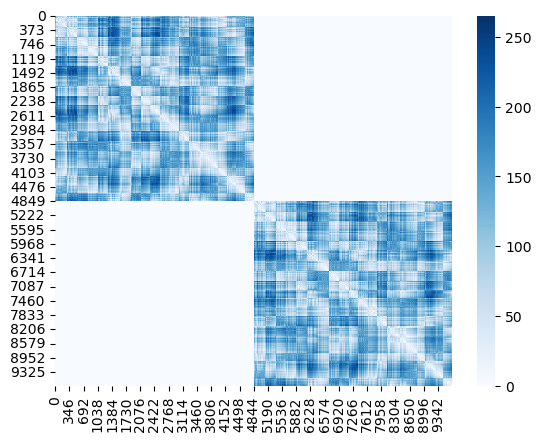

In [18]:
# PLot them 
ax = sns.heatmap(vtx_gd, cmap='Blues')

## fMRI resting state functional connectome

In [19]:
vtx_fc = nb.load(subjectDir + '/func/'+func_acq+ '/surf/' + subjectID + '_surf-fsLR-5k_desc-FC.shape.gii').darrays[0].data

# Fischer transformation
FCz = np.arctanh(vtx_fc)

# replace inf with 0
FCz[~np.isfinite(FCz)] = 0

# Mirror the matrix
FCz = np.triu(FCz,1)+FCz.T

# Remove negative
# Positive correlations
fc_pos = np.copy(FCz)
fc_pos[(0>fc_pos)] = 0
    
# Calculate the sum over the fsLR-5k vertices
vtx_fc_S = np.sum(fc_pos, axis=1)

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_16335/3153723913.py:4: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(vtx_fc)


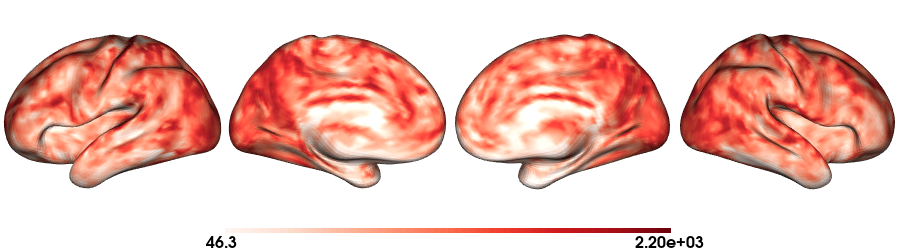

In [20]:
# Plot surface data
plot_hemispheres(c5k_lhi, c5k_rhi, array_name=vtx_fc_S, size=(900, 250), color_bar='bottom', zoom=1.25, 
                 embed_nb=True, interactive=False, share='both', nan_color=(1, 1, 1, 1), 
                 cmap='Reds',transparent_bg=False, color_range=None)

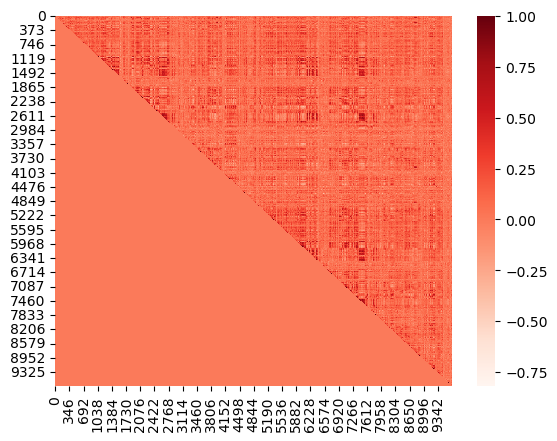

In [21]:
# PLot them 
ax = sns.heatmap(vtx_fc, cmap='Reds')

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_16335/685815315.py:4: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(vtx_fc)


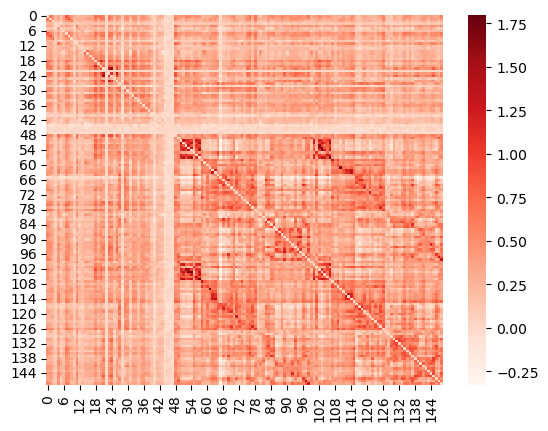

In [24]:
vtx_fc = nb.load(subjectDir + '/func/'+func_acq+ '/surf/' + subjectID + '_surf-fsLR-32k_atlas-schaefer-100_desc-FC.shape.gii').darrays[0].data

# Fischer transformation
FCz = np.arctanh(vtx_fc)

# replace inf with 0
FCz[~np.isfinite(FCz)] = 0

# Mirror the matrix
FCz = np.triu(FCz,1)+FCz.T

    
ax = sns.heatmap(FCz, cmap='Reds')

## DWI sctructural connectome

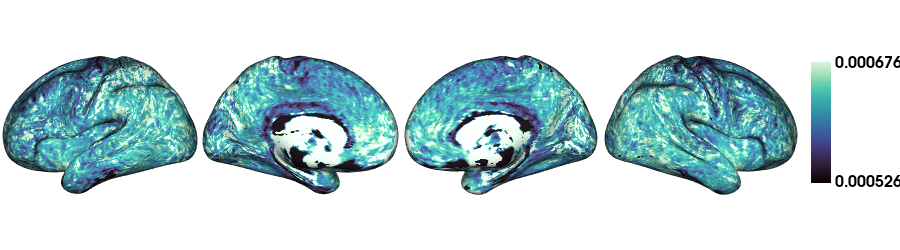

In [133]:
# Plot the surface
feat = load_feat(label='midthickness_ADC', surf='fsLR-32k')
Range=(np.quantile(feat, 0.025), np.quantile(feat, 0.9))
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='mako', transparent_bg=False, color_bar='right')


In [142]:
# load the matrix
vtx_sc = nb.load(subjectDir + '/dwi/connectomes/' + subjectID + '_surf-fsLR-5k_desc-iFOD2-40M-SIFT2_full-connectome.shape.gii').darrays[0].data
vtx_sc = np.triu(vtx_sc,1)+vtx_sc.T

# Calculate the sum over the fsLR-5k vertices
vtx_SC_S = np.sum(vtx_sc,axis=1)

# Get the log sum
vtx_sc_log = np.log(vtx_SC_S)
vtx_sc_log[np.isneginf(vtx_sc_log)] = 0


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_32838/2579744202.py:9: RuntimeWarning: divide by zero encountered in log
  vtx_sc_log = np.log(vtx_SC_S)


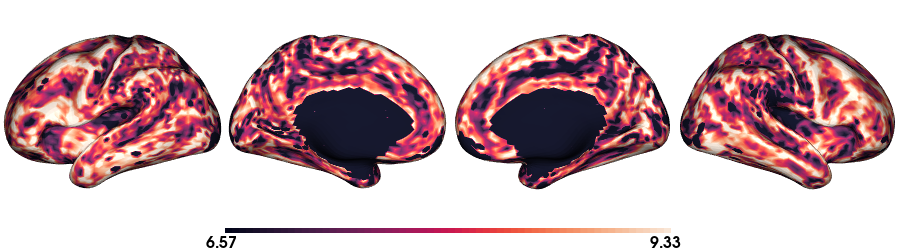

In [143]:
# Plot surface data
feat=vtx_sc_log
Range=(np.quantile(feat, 0.2), np.quantile(feat, 0.9))
plot_hemispheres(c5k_lhi, c5k_rhi, array_name=feat, size=(900, 250), color_bar='bottom', zoom=1.25, 
                 embed_nb=True, interactive=False, share='both', nan_color=(1, 1, 1, 1), color_range=Range,
                 cmap='rocket',transparent_bg=False)

## qT1 MPC matrix

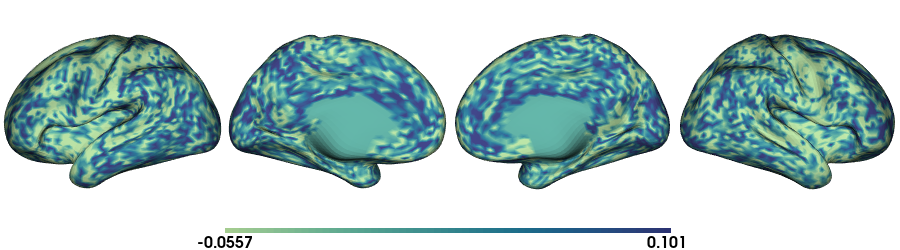

In [135]:
# load the matrix
mtx_mpc = nb.load(subjectDir + '/mpc/acq-T1map/' + subjectID + '_surf-fsLR-5k_desc-MPC.shape.gii').darrays[0].data
    
# Mirror the matrix
MPC = np.triu(mtx_mpc,1)+mtx_mpc.T

# Calculate the sum over the fsLR-5k vertices
mpc_S = np.mean(MPC,axis=1)

# Plot surface data
feat=mpc_S
Range=(np.quantile(feat, 0.2), np.quantile(feat, 0.9))
plot_hemispheres(c5k_lhi, c5k_rhi, array_name=feat, size=(900, 250), color_bar='bottom', zoom=1.25, 
                 embed_nb=True, interactive=False, share='both', nan_color=(1, 1, 1, 1), color_range=Range,
                 cmap='crest',transparent_bg=False)

## flair

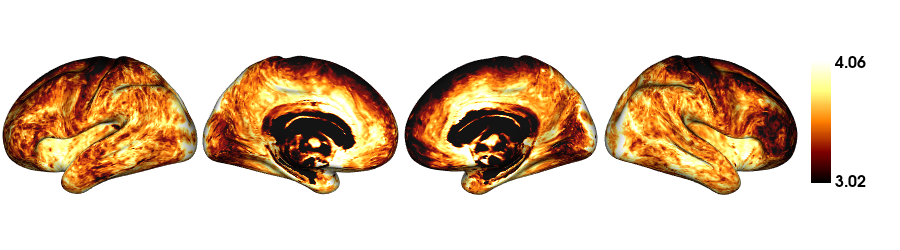

In [136]:
# Plot the surface
feat = load_feat(label='midthickness_flair', surf='fsLR-32k')
Range=(np.quantile(feat, 0.1), np.quantile(feat, 0.98))
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=Range, cmap='afmhot', transparent_bg=False,  color_bar='right')


# 6. Run the group QC

```bash
# Set the variablers
micapipe_img=${MICAPIPE}/micapipe_v0.2.2.sif
bids=/data_/mica3/BIDS_MICs/MICs_release/rawdata
out=/data/mica3/BIDS_MICs/derivatives
fs_lic=/data_/mica1/01_programs/freesurfer-7.3.2/license.txt
tmp=/data/mica2/temporaryNetworkProcessing


# Run micapipe
singularity run --cleanenv \
    -B ${bids}:/bids \
    -B ${out}:/out \
    -B ${tmp}:/tmp \
    -B ${fs_lic}:/opt/licence.txt \
    ${micapipe_img} \
    -bids /bids -out /out -fs_licence /opt/licence.txt -threads 10 -QC
```

# 7. Revise the group QC pdf report


In [121]:
%%bash

firefox /data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0/micapipe_group-QC.pdf

# Happy processing!

